In [1]:
import sys

sys.path.insert(1, '/Users/users/spirov/ThesisProject/Executable')

import numpy as np
from matplotlib import pyplot as plt


import os
import vaex
from cycler import cycler

from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union


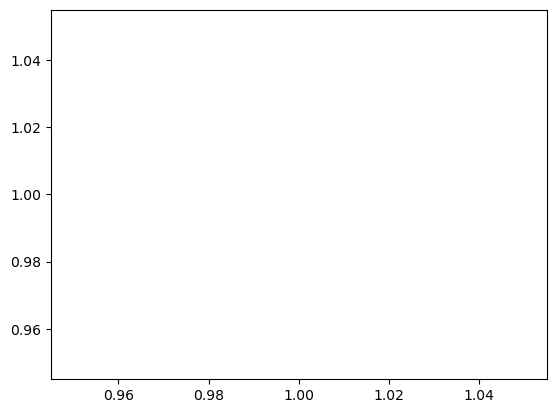

In [2]:


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.rcParams["axes.prop_cycle"] = cycler("color",('indigo','b','r','k','#ff7f0e','g'))
plt.show()

In [3]:


@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts, simps, rho):
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        #[v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        #Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return Drho

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        #self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

   

In [4]:
L = 128
sigma = 8
gamma = 1

def power(k, gamma):
    return k**gamma

def GRF(L, gamma, sigma):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    k2 = kx**2 + ky**2 + kz**2
    smooth_kernel = np.exp(- sigma ** 2 * k2 / 2)
    grf = np.fft.ifftn(
        np.sqrt(power(k2, gamma)) * 
                smooth_kernel * 
                np.fft.fftn(np.random.normal(0, 1, (L, L, L)))).real
    return grf / np.std(grf)

def gradient(data):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    
    datax = -np.fft.ifftn(kx * np.fft.fftn(data)).imag
    datay = -np.fft.ifftn(ky * np.fft.fftn(data)).imag
    dataz = -np.fft.ifftn(kz * np.fft.fftn(data)).imag
    
    return np.transpose(np.array([datax, datay, dataz]),(1,2,3,0))

def Zeldovich(grf, D):
    velocities = gradient(grf)
    X, Y, Z = np.meshgrid(np.arange(L), np.arange(L), np.arange(L))
    points = np.transpose(np.array([X, Y, Z]), (1,2,3,0)) + D * velocities
    return (points.reshape(L**3, 3), velocities.reshape(L**3, 3))

grf = GRF(L, gamma, sigma)
points, velocities = Zeldovich(grf, 20)
m = np.ones(len(points))

In [5]:
from torch.nn.modules.loss import _Loss


import torch
from torch.utils.data import DataLoader
from torch import nn
from NeuralNets import CustomVaexDataset, printNodes, sc, StraightNetwork,Unet,Stefann

from torch.utils.data import Dataset
from DataCore import snapshotPath,L


In [6]:
p3 = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"
test_set = CustomVaexDataset(p3)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=True)


In [7]:
lim = 1  #datapoint reduction factor
sc = 3e4   #scaling factor to allow model to behave itself

l = 11200

n = int(2**int(np.log2(l)))
torch.set_default_dtype(torch.float64)


In [8]:
class myDataset(Dataset):
    def __init__(self, frameDir):
        self.lengt = len(os.listdir(frameDir))
        self.frameDir = frameDir

    def __len__(self):
        return self.lengt

    def __getitem__(self, idx):
        fil = self.frameDir + os.listdir(self.frameDir)[idx]
        df = vaex.open(fil)

        th = df.Th.values[::lim]
        fi = df.Fi.values[::lim]
        R = df.R.values[::lim] / sc
        CZ = df.CZ.values[::lim] / sc


        broken = np.array((CZ, th, fi))
        truth = np.array(R)

        return torch.tensor(broken), torch.tensor(truth)

f = 2

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * l, int(n/(2*f))),
            nn.ReLU(),
            #nn.Dropout(0.35),
            nn.Linear(int(n/(2*f)),int(n/(4*f))),
            nn.Sigmoid(),
            nn.Linear(int(n/(4*f)),int(n/(8*f))),
            nn.ReLU(),
            nn.Linear(int(n/(8*f)),int(n/(2*f))),
            nn.Sigmoid(),
            #nn.Dropout(0.35),
            nn.Linear(int(n/(2*f)),int(n/f)),
            nn.ReLU(),
            nn.Linear(int(n/f),l)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
GoodPath = "/Users/users/spirov/ThesisProject/Snapshots/BigmodelSnapshot.pt"

sd = torch.load(GoodPath,map_location=torch.device('cpu'))




In [10]:
for k in sd.keys():
    print(sd[k].shape)

#sd["linear_relu_stack.0.weight"].shape

torch.Size([2048, 335976])
torch.Size([2048])
torch.Size([1024, 2048])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([4096, 2048])
torch.Size([4096])
torch.Size([111992, 4096])
torch.Size([111992])


In [11]:
class CowardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(335976, 2048),
            nn.ReLU(),
            #nn.Dropout(0.35),
            nn.Linear(2048,1024),
            nn.Sigmoid(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,2048),
            nn.Sigmoid(),
            #nn.Dropout(0.35),
            nn.Linear(2048,4096),
            nn.ReLU(),
            nn.Linear(4096,111992)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
            
            
model =CowardNet() #BottleneckNetwork() # StraightNetwork() #


In [12]:


model.load_state_dict(sd)


<All keys matched successfully>

In [13]:
dataPath = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"

dataset = myDataset(dataPath)

img, label = dataset.__getitem__(0)

with torch.no_grad():
    mod = model(img.reshape(1,3,len(label)))


Text(0, 0.5, 'residual')

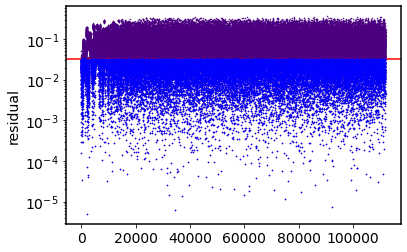

In [14]:
resid = (mod[0]-label).abs()

plt.plot(resid,marker='.',linestyle='',markersize=1)

plt.axhline(1e3/sc,c='r')

filt = resid<(1e3/sc)

plt.plot(np.arange(resid.size()[0])[filt],resid[filt],marker='.',linestyle='',markersize=1)

plt.yscale('log')
plt.ylabel("residual")


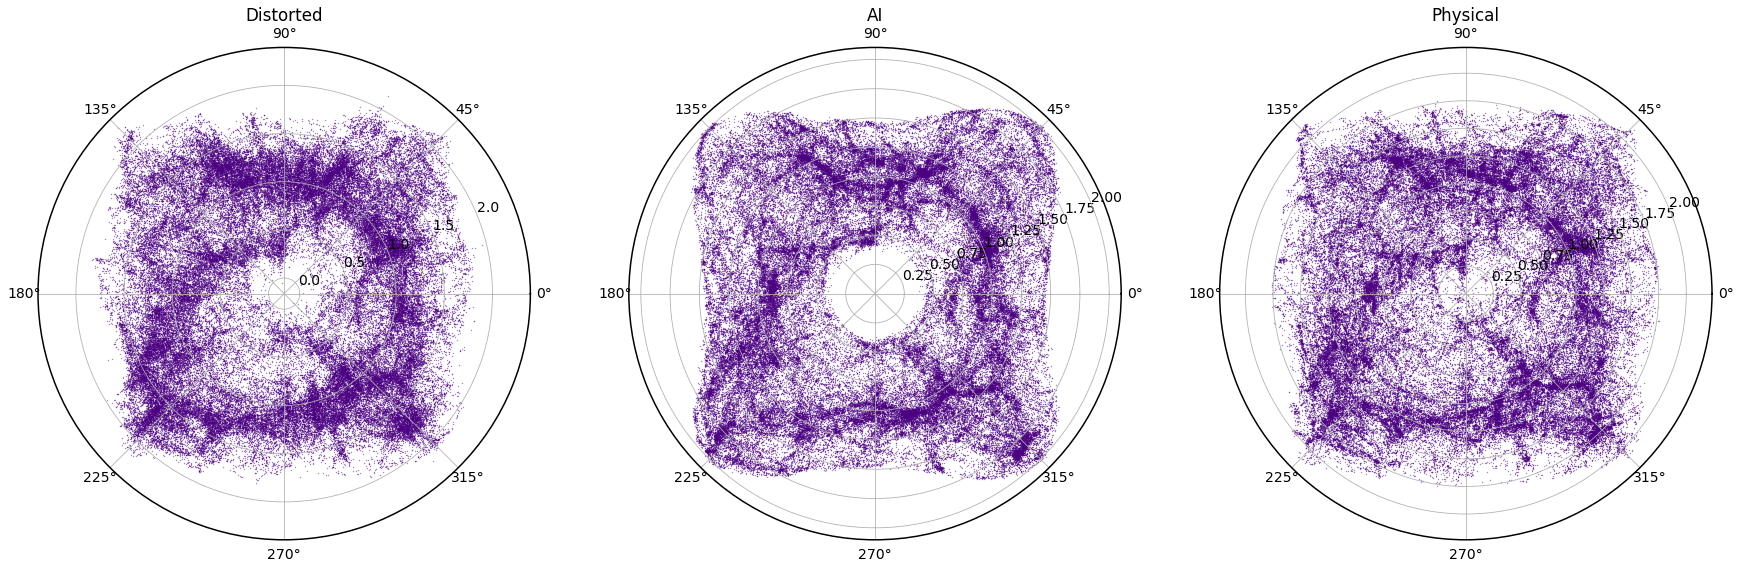

In [15]:
siz = 0.1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.scatter(img[2],img[0],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.scatter(img[2],mod,s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.scatter(img[2],label,s=siz,alpha=0.7)
plt.title("Physical")
plt.show()

In [16]:
dataFrame = vaex.from_arrays(R = label,Fi = img[2],Th = img[1], CZ = img[0], model = mod[0])

In [17]:
dataFrame

#,R,Fi,Th,CZ,model
0,0.8713622156219334,3.0841672228186328,0.3807840704591012,0.8419000719546939,0.8871337920630717
1,0.8447237978105272,-3.0235861870478407,0.42587821511608087,0.9845221160174639,0.872797224720354
2,0.8535352339954823,3.0465721782492885,0.39063877059218305,1.1205266697239216,0.869173027237642
3,0.8123860672609357,3.075873491862033,0.4367188264380599,1.0474579345569057,0.8638824262761712
4,0.9049587939560058,3.0620623249781946,0.3419232189590683,0.5473699548920965,0.8944002351388725
...,...,...,...,...,...
"111,987",1.333130434966427,2.048355139822626,1.6096837230037067,1.28801595747611,1.1521114199470768
"111,988",1.4104021019001687,-2.446416893675759,0.9599477458188982,1.4599635306255618,1.5796523210553786
"111,989",1.076027352158194,2.407712655664305,0.9460785455292607,1.0318277653679917,1.1962415164929954
"111,990",1.8443115274461477,-2.181712754983783,2.287173447023059,1.7965024505853138,1.83976897046727


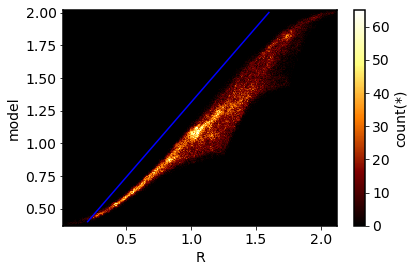

In [18]:
dataFrame.viz.heatmap("R","model")
plt.plot([0.2,2],[0.4,2],c='blue',zorder=100)
plt.show()

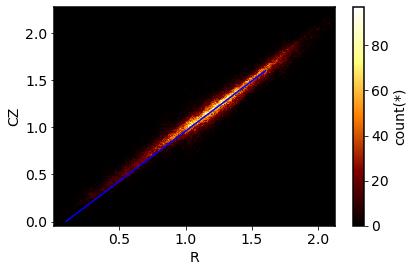

In [19]:
dataFrame.viz.heatmap("R","CZ")
plt.plot([0.1,1.6],[0,1.6],c='blue',zorder=100)
plt.show()

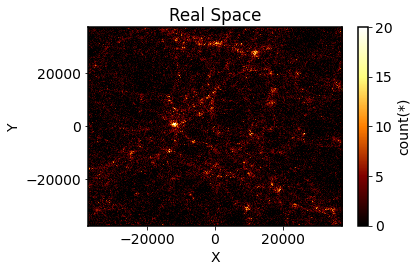

In [20]:
sc = 3.75e4

dataFrame.add_variable("sc",3.75e4)

dataFrame.add_virtual_column("X","R*sin(Th)*cos(Fi)*sc")
dataFrame.add_virtual_column("Y","R*sin(Th)*sin(Fi)*sc")
dataFrame.add_virtual_column("Z","R*cos(Th)*sc")

plt.title("Real Space")
dataFrame.viz.heatmap("X","Y",vmin=0,vmax=20,limits=(-3.75e4,3.75e4))
plt.show()

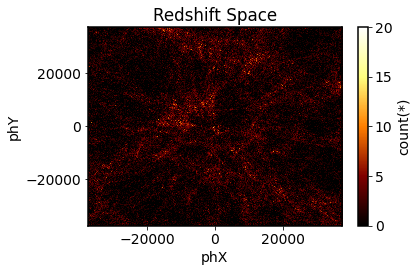

In [21]:
dataFrame.add_virtual_column("phX","CZ*sin(Th)*cos(Fi)*sc")
dataFrame.add_virtual_column("phY","CZ*sin(Th)*sin(Fi)*sc")
dataFrame.add_virtual_column("phZ","CZ*cos(Th)*sc")

plt.title("Redshift Space")
dataFrame.viz.heatmap("phX","phY",vmin=0,vmax=20,limits=(-3.75e4,3.75e4))
plt.show()

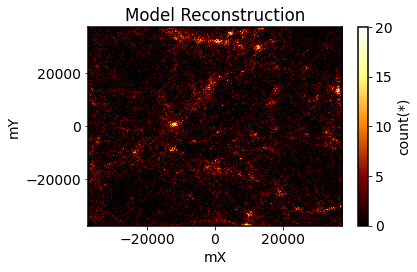

In [22]:
dataFrame.add_virtual_column("mX","model*sin(Th)*cos(Fi)*sc")
dataFrame.add_virtual_column("mY","model*sin(Th)*sin(Fi)*sc")
dataFrame.add_virtual_column("mZ","model*cos(Th)*sc")

plt.title("Model Reconstruction")
dataFrame.viz.heatmap("mX","mY",vmin=0,vmax=20,limits=(-3.75e4,3.75e4))
plt.show()

# DTFE Time

In [23]:
dataFrame.export_hdf5("./kernelSurvivor.hdf5")

In [207]:
dataFrame = vaex.open("./kernelSurvivor.hdf5")

In [208]:
width=3.8e4
zpoint = 0#-1.35e4

In [209]:
dataFrame.add_variable("zpoint",zpoint)
dataFrame.add_variable("width",width)
dataFrame.add_virtual_column("realFilter","((Z-width)<zpoint)*((Z+width)>zpoint)")


In [210]:
dataFrame.add_variable("zpoint",zpoint)
dataFrame.add_variable("width",width)
dataFrame.add_virtual_column("phFilter","((phZ-width)<zpoint)*((phZ+width)>zpoint)")


In [211]:


dataFrame.add_variable("zpoint",zpoint)
dataFrame.add_variable("width",width)
dataFrame.add_virtual_column("mFilter","((mZ-width)<zpoint)*((mZ+width)>zpoint)")


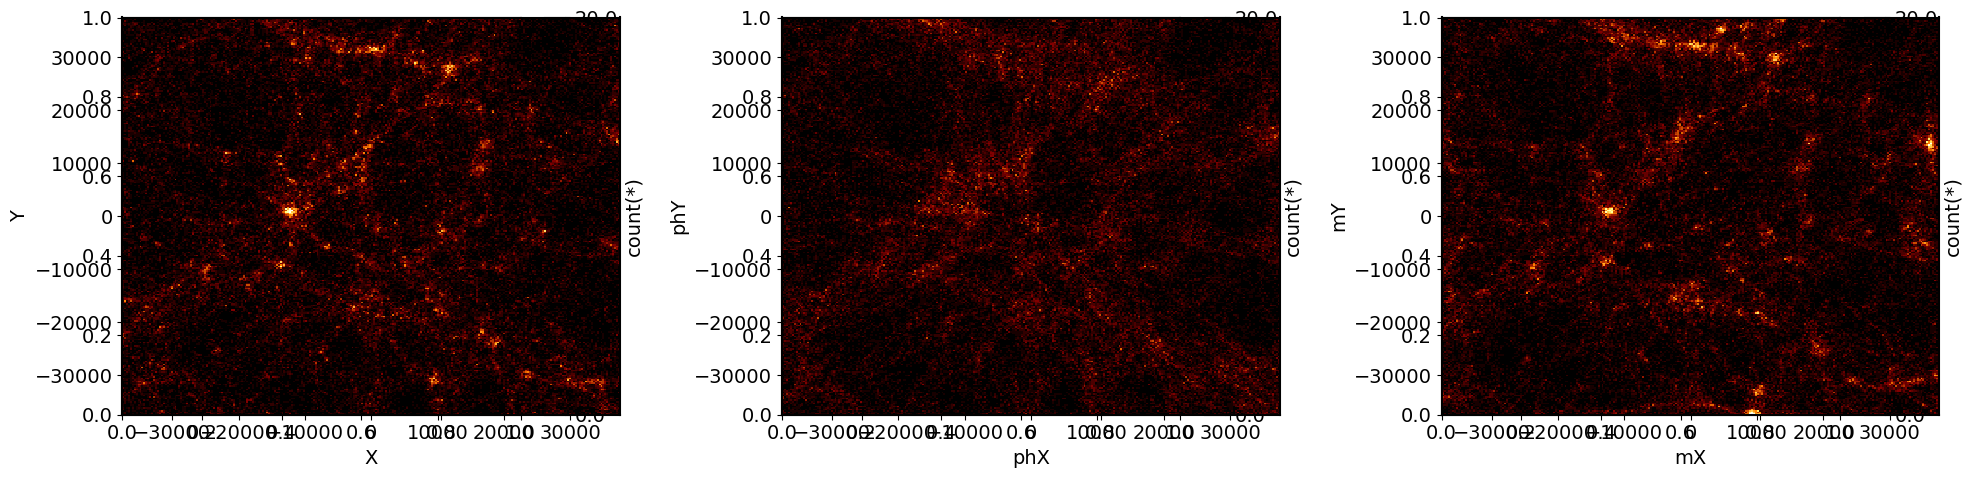

In [212]:
plt.figure(figsize=(20,5))
dataFrame.viz.heatmap([["X","Y"],["phX","phY"],["mX","mY"]],limits=(-3.75e4,3.75e4),vmin=0,vmax=20,)

# Real Space

In [278]:
df = dataFrame[dataFrame.realFilter]

p=np.array((df.X.values,df.Y.values,df.Z.values)).T
m=np.ones(len(df))

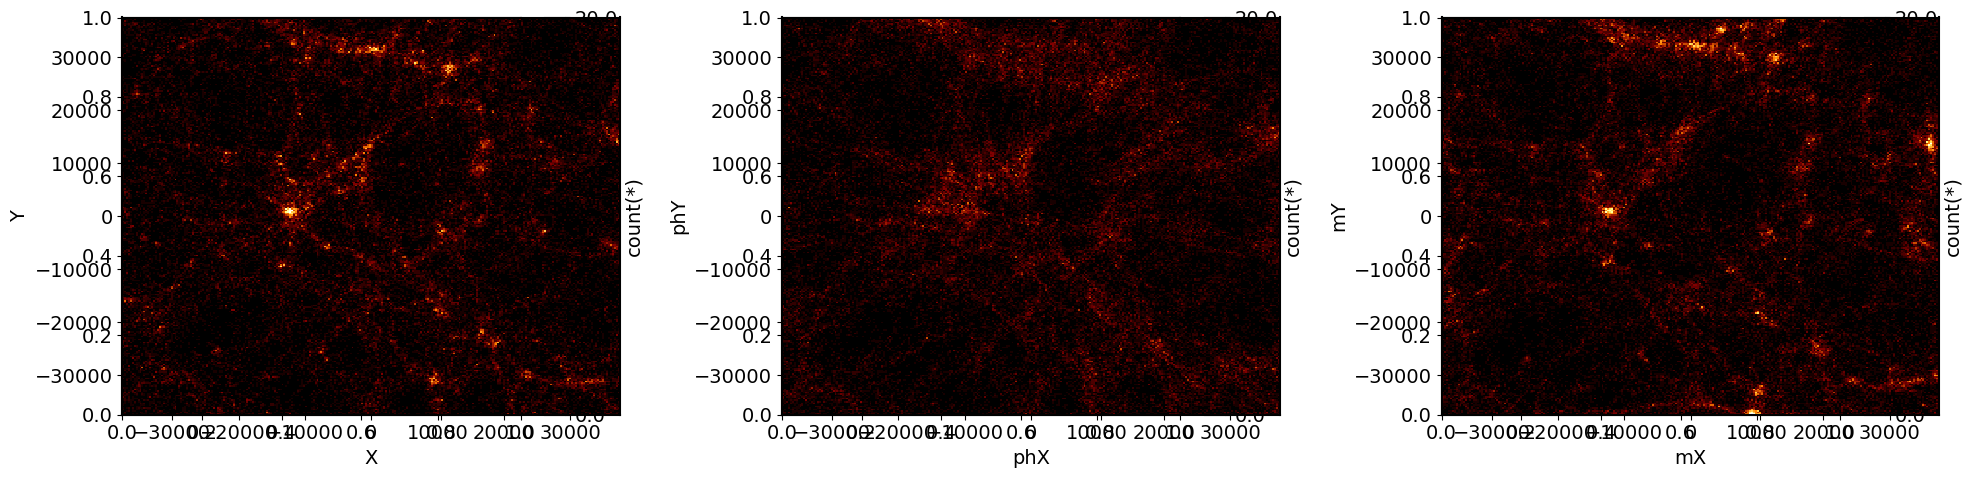

In [279]:
plt.figure(figsize=(20,5))
df.viz.heatmap([["X","Y"],["phX","phY"],["mX","mY"]],limits=(-3.75e4,3.75e4),vmin=0,vmax=20)

In [280]:
%%time
dtfe = DTFE(p, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 3.6 s, sys: 17.7 ms, total: 3.61 s
Wall time: 3.63 s


In [281]:
n=256
L = 75000

z = zpoint

X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(zpoint-width,zpoint+width,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())


In [282]:
den = d.reshape(n,n,n)
dens = den[den>0]

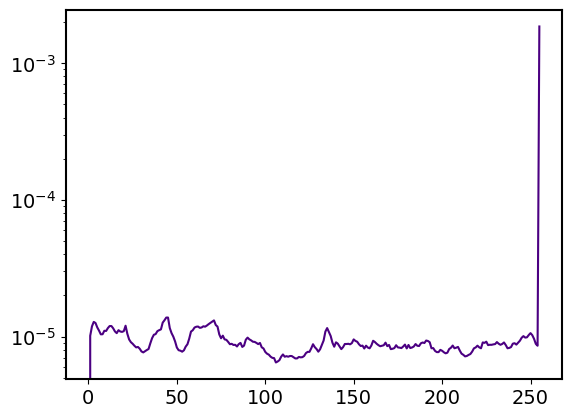

In [283]:
plt.plot(den.sum((0,1)))
plt.yscale('log')
plt.show()

In [284]:
vmin = 1e-9
l=1
vmax=5e-7

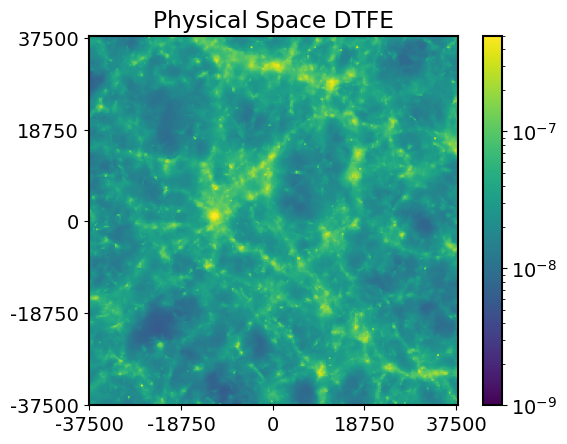

In [285]:

plt.imshow(den[:,:,l:-l].sum(2),norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))


plt.title("Physical Space DTFE")
plt.colorbar()
plt.show()

# Phase DTFE

In [286]:
df = dataFrame[dataFrame.phFilter]

p=np.array((df.phX.values,df.phY.values,df.phZ.values)).T
m=np.ones(len(df))


In [287]:
%%time
dtfe = DTFE(p, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 4.3 s, sys: 27.2 ms, total: 4.32 s
Wall time: 4.33 s


In [288]:
X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(zpoint-width,zpoint+width,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())
den = d.reshape(n,n,n)
dens = den[den>0]

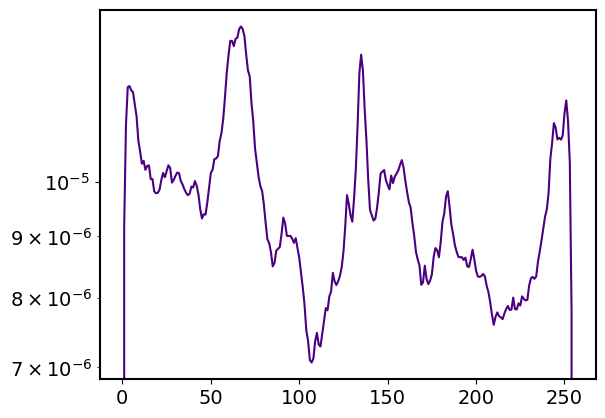

In [289]:
plt.plot(den.sum((0,1)))
plt.yscale('log')
plt.show()

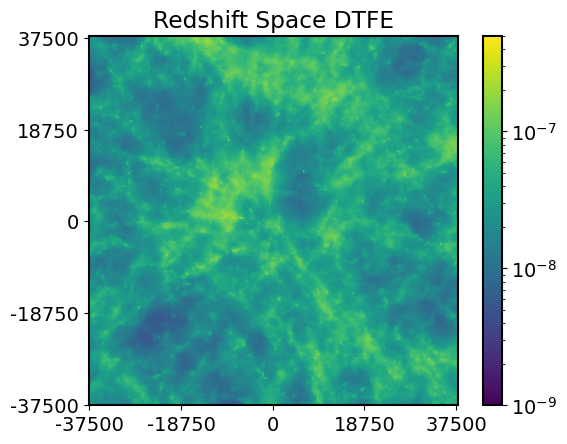

In [290]:


plt.imshow(den[:,:,l:-l].sum(2),norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))


plt.title("Redshift Space DTFE")
plt.colorbar()
plt.show()

In [291]:
df = dataFrame[dataFrame.mFilter]

p=np.array((df.mX.values,df.mY.values,df.mZ.values)).T
m=np.ones(len(df))

dtfe = DTFE(p, m)

X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(zpoint-width,zpoint+width,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())
den = d.reshape(n,n,n)
dens = den[den>0]

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients


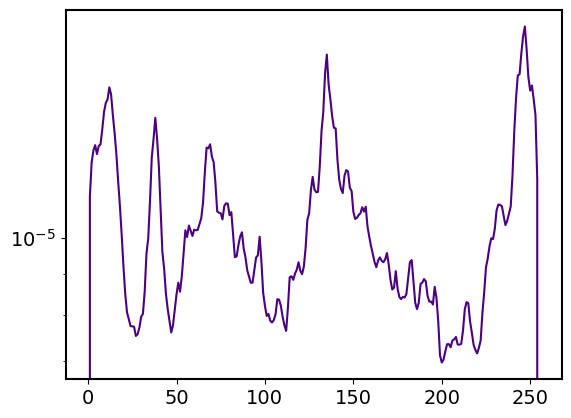

In [292]:
plt.plot(den.sum((0,1)))
plt.yscale('log')
plt.show()

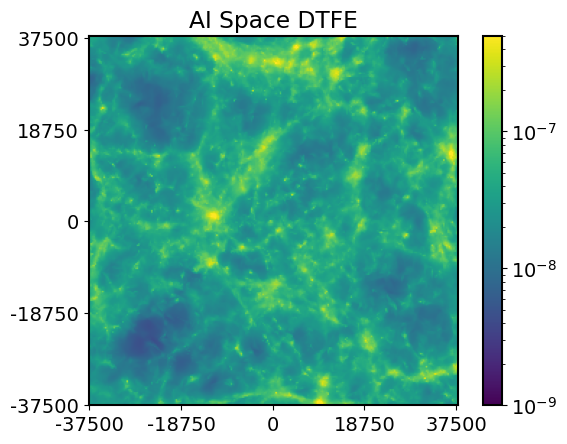

In [293]:

plt.imshow(den[:,:,l:-l].sum(2),norm="log",origin="lower",vmin=vmin,vmax=vmax)
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5,dtype=int))


plt.title("AI Space DTFE")
plt.colorbar()
plt.show()